<a href="https://colab.research.google.com/github/arturoduar/detection/blob/main/Style_Pattern_Trainer_Skeleton_Partial_Conv_Training_TensorFlow_ClassicKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Transfer Learn from ResNet50 

In [ ]:
# import only the base of trained model (convolution layers)
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

In [ ]:
print(base_model.summary())

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)


In [ ]:
# construct the final dense layers for output of N classes (6 in thid case)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
preds = tf.keras.layers.Dense(18, activation = 'softmax')(x)

In [ ]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [ ]:
# Train layers starting from train_threshold (including base layers) - ResNet50 has 175 conv layers
train_threshold = 110 

# Non-Trainable part - some base layers 0 - up to train_threshold (a number of conv layers are trained for fine-tuning / ty to reduce overfitting)
for layer in model.layers[:train_threshold]:
     layer.trainable = False

# Trainable part - some base layers + dense NN 
for layer in model.layers[train_threshold:]:
    layer.trainable = True     


In [ ]:
print(model.summary())

Load data for classifying N features from images 

Dir structure should be:


    /DataDirectory/
            class1/
            class2/
            ...
            classN/



In [ ]:
data_root = ("/content/drive/MyDrive/detect/data/style-dataset-sub/images")


In [ ]:
# Image shape down to (224, 224) to match ResNet50

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

In [ ]:
datagen_kwargs = dict(preprocessing_function= tf.keras.applications.resnet50.preprocess_input, validation_split=.20)

In [ ]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory( TRAINING_DATA_DIR,
                                                    subset="validation",
                                                    shuffle=True,
                                                    color_mode = 'rgb',
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory( TRAINING_DATA_DIR,
                                                    subset="training",
                                                    shuffle=False,
                                                    color_mode = 'rgb',
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    target_size=IMAGE_SHAPE)

In [ ]:
print (train_generator.class_indices)

In [ ]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Do the training

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit( train_generator, 
                epochs=70,
                #verbose=1,
                steps_per_epoch=steps_per_epoch,
                validation_data=valid_generator,
                validation_steps=val_steps_per_epoch).history

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

106/106 [==============================] - 16s 153ms/step - loss: 2.5814 - accuracy: 0.7325
Final loss: 2.58
Final accuracy: 73.25%


In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
# save the model to drive
model.save("/content/drive/MyDrive/detect/style_models/style_predictor1")

In [ ]:
# fetch the model from drive (just to test it was generated correctly)
from keras.models import load_model
model2 = load_model("/content/drive/MyDrive/detect/style_models/style_predictor1")

In [ ]:
# run stored model on validation set
final_loss, final_accuracy = model2.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

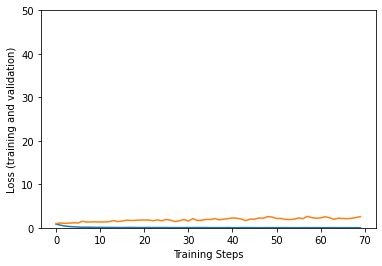

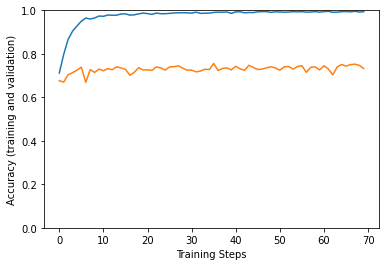

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
Y_pred = model2.predict_generator(valid_generator, val_steps_per_epoch)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
print(cm)

In [ ]:
print('Classification Report')
target_names = ['Bohemian', 'Casual', 'Conservative', 'Dressy', 'Elegant', 'Ethnic', 'Fairy', 'Feminine', 'Glamour', 'Lolita', 'Mode', 'Modest', 'Preppy', 'Retro', 'Rock', 'Sexy',  'Sporty', 'Street']
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
print(f"Confusion matrix:\n{disp.confusion_matrix}")

fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, values_format='')